# Tabm，一个自带集成特效的深度学习模型

Tabm是一个可以用于结构化(tabular)数据的分类和回归任务的深度学习模型。

它的名字是 Tabular  和 Multiple单词开头的拼接。

含义是：A Tabular DL model that makes Multiple predictions。

顾名思义，Tabm模型能够同时输出多个预测，并且取这些预测的平均作为最终的输出。

这是一种非常经典的模型集成的思想，叫做bagging，就像随机森林做的那样。

你可以这样大致理解Tabm的原理。

1，Tabm由许多MLP小模型(例如k=32个)组成的，每个小模型都可以输出独立的预测，每个小模型的loss也是独立计算的。最终的预测是它们的预测结果的平均。

2，为了减少总的权重参数规模，这些小模型有相当多的权重参数是共享的，因此Tabm的实际权重大小是显著小于许多个完全独立的小模型的，这种权重共享的设计实际上也起到了一定的正则化的作用，可以提升模型的效果。

3，Tabm还引入了精心设计的对数值特征的PLREmbedding技术以及模型参数初始化方法，这些设计也能显著提升模型的效果。


参考: https://github.com/yandex-research/tabm

本范例我们使用Covertype数据集，它的目标是预测植被覆盖类型，是一个七分类问题。

公众号**算法美食屋**后台回复关键词：torchkeras，获取本文notebook源码和所用Covertype数据集下载链接。



In [ ]:
!pip install tabm 
!pip install torchkeras==4.0.5

## 一，准备数据

In [2]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split

file_path = "covertype.parquet"
dfdata = pd.read_parquet(file_path)

cat_cols = ['Wilderness_Area', 'Soil_Type']
num_cols = ['Elevation','Aspect','Slope','Horizontal_Distance_To_Hydrology',
 'Vertical_Distance_To_Hydrology','Horizontal_Distance_To_Roadways',
 'Hillshade_9am','Hillshade_Noon','Hillshade_3pm','Horizontal_Distance_To_Fire_Points']
target_col = 'Cover_Type'

print("dfdata.shape = ",dfdata.shape)
print("target_col = ", target_col)
print('cat_cols = ', cat_cols)  
print('num_cols = ', num_cols[:3]+['...'])

dftmp, dftest_raw = train_test_split(dfdata, random_state=42, test_size=0.2)
dftrain_raw, dfval_raw = train_test_split(dftmp, random_state=42, test_size=0.2)

print("len(dftrain) = ",len(dftrain_raw))
print("len(dfval) = ",len(dfval_raw))
print("len(dftest) = ",len(dftest_raw))


dfdata.shape =  (581012, 13)
target_col =  Cover_Type
cat_cols =  ['Wilderness_Area', 'Soil_Type']
num_cols =  ['Elevation', 'Aspect', 'Slope', '...']
len(dftrain) =  371847
len(dfval) =  92962
len(dftest) =  116203


In [4]:
from torchkeras.tabular import TabularPreprocessor
from sklearn.preprocessing import OrdinalEncoder

#特征工程
pipe = TabularPreprocessor(cat_features = cat_cols, 
                           embedding_features=cat_cols)
encoder = OrdinalEncoder()

dftrain = pipe.fit_transform(dftrain_raw.drop(target_col,axis=1))
dftrain[target_col] = encoder.fit_transform(
    dftrain_raw[target_col].values.reshape(-1,1)).astype(np.int32)

dfval = pipe.transform(dfval_raw.drop(target_col,axis=1))
dfval[target_col] = encoder.transform(
    dfval_raw[target_col].values.reshape(-1,1)).astype(np.int32)

dftest = pipe.transform(dftest_raw.drop(target_col,axis=1))
dftest[target_col] = encoder.transform(
    dftest_raw[target_col].values.reshape(-1,1)).astype(np.int32)


  0%|          | 0/2 [00:00<?, ?it/s]

In [5]:
from torchkeras.tabular import TabularDataset
from torch.utils.data import Dataset,DataLoader 

def get_dataset(dfdata):
    return TabularDataset(
                data = dfdata,
                task = 'multiclass', #regression, binary, multiclass
                target = [target_col],
                continuous_cols = pipe.get_numeric_features(),
                categorical_cols = pipe.get_embedding_features()
        )

def get_dataloader(ds,batch_size=1024,num_workers=0,shuffle=False):
    dl = DataLoader(
            ds,
            batch_size=batch_size,
            shuffle=shuffle,
            num_workers=num_workers,
            pin_memory=False,
        )
    return dl 
    
ds_train = get_dataset(dftrain)
ds_val = get_dataset(dfval)
ds_test = get_dataset(dftest)

dl_train = get_dataloader(ds_train,shuffle=True)
dl_val = get_dataloader(ds_val,shuffle=False)
dl_test = get_dataloader(ds_test,shuffle=False)


In [6]:
for batch in dl_train:
    break
    
    

## 二，定义模型

In [7]:
import math
import random
from copy import deepcopy
from dataclasses import dataclass, field
from typing import Any, List, Literal, NamedTuple, Optional, Tuple, Union
import torch 
from torch import Tensor
from torch import nn 
import tabm 
from torchkeras.tabular.config import ModelConfig

@dataclass
class TabMConfig(ModelConfig):
    k: int = field(
        default=32,
        metadata={"help": "Number of parallel predictions to make (default: 32)"}
    )
    n_blocks: int = field(
        default=3,
        metadata={"help": "Number of Linear blocks in Tabm (default: 3)"}
    )
    d_block: int = field(
        default=512,
        metadata={"help": "Dimension of block in Tabm (default: 512)"}
    )
    
    plr_embed_dim: int = field(
            default=64,
            metadata={"help": "The embedding dimension of the PLREmbedding. Defaults to 64"},
    )
    
    plr_frequencies_num: int = field(
            default=96,
            metadata={"help": "The n_frequencies of the PLREmbedding. Defaults to 96"},
    )
    
    plr_frequency_scale: float = field(
            default=0.013675285379929491,
            metadata={"help": "The frequency_scale of the PLREmbedding. Defaults to 0.013675285379929491"},
    )
    dropout: float = field(default=0.1)
    scaling_init: str = field(default="normal")
    _module_src: str = field(default="models.tabm")
    _model_name: str = field(default="TabMModel")
    _config_name: str = field(default="TabMConfig")


class CatEmbeddings(nn.Module):
    def __init__(
        self,
        categorical_embedding_dims,
        embedding_dropout = 0.0,
    ):
        super().__init__()
        self.categorical_embedding_dims = categorical_embedding_dims
        self.cat_embedding_layers = nn.ModuleList(
            [nn.Embedding(x, y) for x, y in categorical_embedding_dims])
        if embedding_dropout > 0:
            self.embd_dropout = nn.Dropout(embedding_dropout)
        else:
            self.embd_dropout = None

    def forward(self, x):
        # (B, N)
        x_cat = x
        assert x_cat.shape[1] == len(
            self.cat_embedding_layers
        ), "categorical_data must have same number of columns as categorical embedding layers"
        if x_cat.shape[1] > 0:
            embed = torch.cat(
                [
                    embedding_layer(x_cat[:, i])
                    for i, embedding_layer in enumerate(self.cat_embedding_layers)
                ],
                dim=1,
            )
        else:
            embed = torch.empty(0, 0)
        if self.embd_dropout is not None:
            embed = self.embd_dropout(embed)
        return embed
    
class PeriodicEmbeddings(nn.Module):
    def __init__(
        self, n_features: int, n_frequencies: int, frequency_scale: float
    ) -> None:
        super().__init__()
        self.frequencies = nn.Parameter(
            torch.normal(0.0, frequency_scale, (n_features, n_frequencies))
        )
    def forward(self, x: Tensor) -> Tensor:
        assert x.ndim == 2
        x = 2 * torch.pi * self.frequencies[None] * x[..., None]
        x = torch.cat([torch.cos(x), torch.sin(x)], -1)
        return x


class PLREmbeddings(nn.Sequential):
    def __init__(
        self,
        n_features: int,
        n_frequencies: int,
        frequency_scale: float,
        d_embedding: int,
    ) -> None:
        super().__init__(
            PeriodicEmbeddings(n_features, n_frequencies, frequency_scale),
            nn.Linear(2 * n_frequencies, d_embedding),
            nn.ReLU(),
        )


class TabMModel(nn.Module):
    def __init__(self, config, **kwargs):
        super().__init__()
        self.hparams = config
        
        d_numerical = self.hparams.continuous_dim
        categories = self.hparams.categorical_cardinality
        n_classes = self.hparams.output_dim
        d_out = n_classes if n_classes is not None else 1
        d_block = self.hparams.d_block
        n_blocks = self.hparams.n_blocks
        dropout = self.hparams.dropout
        k = self.hparams.k
        scaling_init = self.hparams.scaling_init

        self.cat_embeddings = CatEmbeddings(
            categorical_embedding_dims = self.hparams.embedding_dims
        ) if categories else None
        
        self.num_embeddings = PLREmbeddings(
            n_features = d_numerical,
            n_frequencies = self.hparams.plr_frequencies_num,
            frequency_scale = self.hparams.plr_frequency_scale,
            d_embedding = self.hparams.plr_embed_dim
        ) if d_numerical>0 else None

        d_in = d_numerical * self.hparams.plr_embed_dim + self.hparams.embedded_cat_dim
        self.tabm_core = nn.Sequential(
            tabm.EnsembleView(k=k),   # (B, d_in) -> (B, k, d_in)
            tabm.MLPBackboneBatchEnsemble(
                d_in=d_in,
                n_blocks=n_blocks,
                d_block=d_block,
                dropout=dropout,
                k=k,
                tabm_init=True,
                scaling_init=scaling_init,
                start_scaling_init_chunks=None
            ),
            tabm.LinearEnsemble(512, d_out, k=k) # -> (B, k, d_out)
        )
        self.loss = getattr(nn, self.hparams.loss)()


    def forward(self, inputs):
        x_cat,x_num = inputs["categorical"], inputs["continuous"]
        x = []
        if self.num_embeddings is not None:
            x.append(
                x_num
                if self.num_embeddings is None
                else self.num_embeddings(x_num).flatten(1)
            )
            
        if self.cat_embeddings is not None:
            x.append(self.cat_embeddings(x_cat))

        x = torch.cat(x, dim=1)
        logits = self.tabm_core(x)
        
        with torch.no_grad():
            if self.hparams.task == 'binary':
                probs = torch.sigmoid(logits)
            elif self.hparams.task == 'multiclass':
                probs = torch.softmax(logits, dim=-1)
            else:
                probs = logits
            yhat = probs.mean(1)

        return {"logits": logits, "yhat":yhat}

    def compute_loss(self, output, target):
        y_pred = output["logits"]
        # TabM产生k个预测，需要分别训练
        # 回归: (batch_size, k) -> (batch_size * k,)
        # 分类: (batch_size, k, n_classes) -> (batch_size * k, n_classes)
        y_pred = y_pred.flatten(0, 1)
        # 复制目标以匹配预测的形状
        # (batch_size,) -> (batch_size * k,)
        y_true = target.repeat_interleave(self.hparams.k)
        computed_loss = self.loss(y_pred.squeeze(), y_true.squeeze())
        return computed_loss
    
    
    def predict(self, batch):
        self.eval()
        output = self.forward(batch)
        return output['yhat']
    

# 配置模型
model_config = TabMConfig(
    task="multiclass",  #regression, binary, multiclass
    k=32
)

# 合并数据集配置
config = model_config.merge_dataset_config(ds_train)

print('模型配置:')
print('categorical_cardinality =', config.categorical_cardinality)
print('embedding_dims =', config.embedding_dims)

# 初始化模型
net = TabMModel(config=config)

print(net.hparams.output_dim)


模型配置:
categorical_cardinality = [4, 40]
embedding_dims = [(4, 2), (40, 20)]
7


In [8]:
output = net.forward(batch)
loss = net.compute_loss(output,batch['target'])
print(loss)


tensor(1.9471, grad_fn=<NllLossBackward0>)


## 三，训练模型

In [9]:
from torchkeras import KerasModel 
from torchkeras.tabular import StepRunner 
KerasModel.StepRunner = StepRunner 


In [10]:
import torch 
from torch import nn 
class Accuracy(nn.Module):
    def __init__(self):
        super().__init__()

        self.correct = nn.Parameter(torch.tensor(0.0),requires_grad=False)
        self.total = nn.Parameter(torch.tensor(0.0),requires_grad=False)

    def forward(self, preds: torch.Tensor, targets: torch.Tensor):
        preds = preds.argmax(dim=-1)
        targets = targets.reshape(-1)
        m = (preds == targets).sum()
        n = targets.shape[0] 
        self.correct += m 
        self.total += n
        
        return m/n

    def compute(self):
        return self.correct.float() / self.total 
    
    def reset(self):
        self.correct -= self.correct
        self.total -= self.total
        

In [13]:
keras_model = KerasModel(net,
                   loss_fn=None,
                   optimizer = torch.optim.AdamW(net.parameters(),lr = 1e-3),
                   metrics_dict = {"acc":Accuracy()}
                   )


Detected kernel version 4.18.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


<<<<<< ⚡️ cuda is used >>>>>>


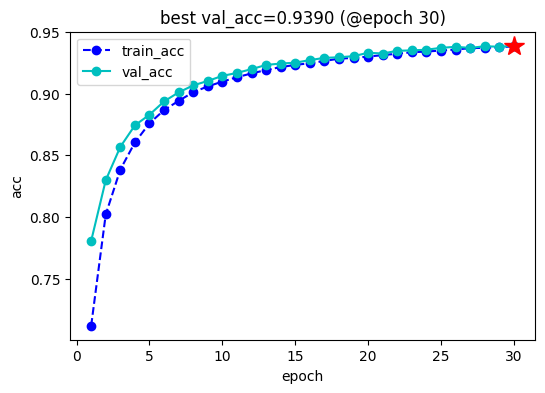

,epoch,train_loss,train_acc,lr,val_loss,val_acc
0,1,0.706615,0.711688,0.001,0.522979,0.780545
1,2,0.498825,0.801983,0.001,0.430890,0.829801
2,3,0.433016,0.838444,0.001,0.372017,0.856866
3,4,0.391631,0.860443,0.001,0.337021,0.874346
4,5,0.362974,0.875981,0.001,0.312029,0.882952
5,6,0.342666,0.886711,0.001,0.293012,0.893752
6,7,0.326724,0.894201,0.001,0.276800,0.901110
7,8,0.313918,0.901196,0.001,0.262480,0.906747
8,9,0.304360,0.905975,0.001,0.254953,0.910383
9,10,0.295499,0.909828,0.001,0.244781,0.914470


In [14]:
keras_model.fit(
    train_data = dl_train,
    val_data= dl_val,
    ckpt_path='checkpoint',
    epochs=30,
    patience=10,
    monitor="val_acc", 
    mode="max",
    plot = True,
    wandb = False
)


## 四，评估模型

In [15]:
keras_model.evaluate(dl_train)

100%|██████████████████████████████| 364/364 [00:15<00:00, 23.30it/s, val_acc=0.947, val_loss=0.165]


{'val_loss': 0.1648734294614949, 'val_acc': 0.9472041130065918}

In [16]:
keras_model.evaluate(dl_val)

100%|████████████████████████████████| 91/91 [00:03<00:00, 24.70it/s, val_acc=0.939, val_loss=0.183]


{'val_loss': 0.1828107291853035, 'val_acc': 0.938964307308197}

In [17]:
keras_model.evaluate(dl_test)

100%|██████████████████████████████| 114/114 [00:04<00:00, 23.02it/s, val_acc=0.939, val_loss=0.181]


{'val_loss': 0.18126998371199557, 'val_acc': 0.9390290975570679}

## 五，使用模型

In [18]:
from tqdm import tqdm 
net = net.cpu()
net.eval()
preds = []
with torch.no_grad():
    for batch in tqdm(dl_test):
        preds.append(net.predict(batch))
    

100%|██████████| 114/114 [01:04<00:00,  1.77it/s]


In [19]:
yhat_list = [yd.argmax(dim=-1).tolist() for yd in preds]
yhat = []
for yd in yhat_list:
    yhat.extend(yd)
yhat = encoder.inverse_transform(np.array(yhat).reshape(-1,1))

In [20]:
dftest_raw = dftest_raw.rename(columns = {target_col: 'y'})
dftest_raw['yhat'] = yhat

In [21]:
from sklearn.metrics import classification_report
print(classification_report(y_true = dftest_raw['y'],y_pred = dftest_raw['yhat']))

              precision    recall  f1-score   support

           1       0.95      0.92      0.94     42557
           2       0.94      0.96      0.95     56500
           3       0.93      0.96      0.94      7121
           4       0.91      0.79      0.85       526
           5       0.86      0.83      0.84      1995
           6       0.90      0.89      0.89      3489
           7       0.94      0.94      0.94      4015

    accuracy                           0.94    116203
   macro avg       0.92      0.90      0.91    116203
weighted avg       0.94      0.94      0.94    116203



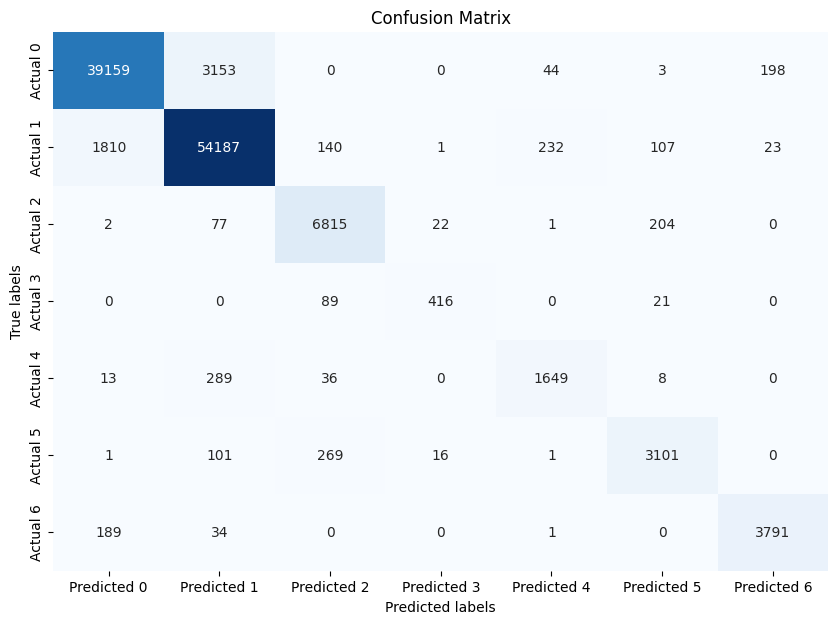

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


# 计算混淆矩阵
cm = confusion_matrix(dftest_raw['y'], dftest_raw['yhat'])

# 将混淆矩阵转换为DataFrame
df_cm = pd.DataFrame(cm, index=['Actual {}'.format(i) for i in range(cm.shape[0])],
                     columns=['Predicted {}'.format(i) for i in range(cm.shape[1])])

# 使用seaborn绘制混淆矩阵
plt.figure(figsize=(10,7))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

## 六，保存模型

最佳模型权重已经保存在ckpt_path = 'checkpoint'位置了。

In [23]:
net.load_state_dict(torch.load('checkpoint',weights_only=True))

<All keys matched successfully>

## 七，与LightGBM对比

In [24]:
import pandas as pd 
import lightgbm as lgb
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import accuracy_score 


dftmp, dftest_raw = train_test_split(dfdata, random_state=42, test_size=0.2)
dftrain_raw, dfval_raw = train_test_split(dftmp, random_state=42, test_size=0.2)

dftrain = dftrain_raw.copy()
dfval = dfval_raw.copy()
dftest = dftest_raw.copy()

target_col = 'Cover_Type'
cat_cols = ['Wilderness_Area', 'Soil_Type']

encoder = OrdinalEncoder()

dftrain[target_col] = encoder.fit_transform(dftrain[target_col].values.reshape(-1,1)) 
dfval[target_col] = encoder.transform(dfval[target_col].values.reshape(-1,1))
dftest[target_col] = encoder.transform(dftest[target_col].values.reshape(-1,1))

for col in cat_cols:
    dftrain[col] = dftrain[col].astype(int)
    dfval[col] = dfval[col].astype(int)
    dftest[col] = dftest[col].astype(int)

ds_train = lgb.Dataset(dftrain.drop(columns=[target_col]), label=dftrain[target_col],categorical_feature=cat_cols)
ds_val = lgb.Dataset(dfval.drop(columns=[target_col]), label=dfval[target_col],categorical_feature=cat_cols)
ds_test = lgb.Dataset(dftest.drop(columns=[target_col]), label=dftest[target_col],categorical_feature=cat_cols)


import lightgbm as lgb

params = {
    'n_estimators':500,
    'boosting_type': 'gbdt',
    'objective':'multiclass',
    'num_class': 7,  # 类别数量
    'metric': 'multi_logloss', 
    'learning_rate': 0.01,
    'verbose': 1,
    'early_stopping_round':50
}
model = lgb.train(params, ds_train, 
        valid_sets=[ds_val], 
        valid_names=['validate']
        )

y_pred_val = model.predict(dfval.drop(target_col,axis = 1), num_iteration=model.best_iteration)
y_pred_val = np.argmax(y_pred_val, axis=1)

y_pred_test = model.predict(dftest.drop(target_col,axis = 1), num_iteration=model.best_iteration)
y_pred_test = np.argmax(y_pred_test, axis=1)

val_score = accuracy_score(dfval[target_col], y_pred_val)
test_score = accuracy_score(dftest[target_col], y_pred_test) 

print('val_score = ',val_score)
print('test_score = ' , test_score)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.014433 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2219
[LightGBM] [Info] Number of data points in the train set: 371847, number of used features: 12
[LightGBM] [Info] Start training from score -1.009334
[LightGBM] [Info] Start training from score -0.717530
[LightGBM] [Info] Start training from score -2.789050
[LightGBM] [Info] Start training from score -5.354306
[LightGBM] [Info] Start training from score -4.127223
[LightGBM] [Info] Start training from score -3.510637
[LightGBM] [Info] Start training from score -3.341909
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	validate's multi_logloss: 0.408343
val_score =  0.8321464684494739
test_score =  0.8329389086340284
